In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchlensmaker as tlm

from xxchallenge import *


from torchlensmaker.elements.optical_surfaces import CollisionSurface
from torchlensmaker.core.physics import reflection

#torch.autograd.set_detect_anomaly(True)

"""
A -0.22063622892378973
B 0.1448788770276808
G1 -906.7688700167654
G2 104.9561191449074
"""


# Parameters
A = tlm.parameter(-0.22)
B = tlm.parameter(0.14)
G0 = tlm.parameter(0)    # must be < 0
G1 = tlm.parameter(-900)
G2 = tlm.parameter(80)


# Primary mirror
primary = tlm.Parabola(1800, A=A, normalize=True)
primary_data = StoreVar(lambda data: data)

# Secondary mirror
secondary = tlm.Parabola(200, A=B, normalize=True)
secondary_data = StoreVar(lambda data: data)

# Final rod
cylinder = tlm.ImplicitCylinder(*torch.tensor([-50/2, 50/2, 37.02/2], dtype=torch.float64).unbind())
rod_data = StoreVar(lambda data: data)

# Optical model
optics = tlm.Sequential(
    tlm.Gap(-1000),
    XXLightSource.load(),
    tlm.AbsolutePosition(x=G0),
    
    primary_data,
    tlm.ReflectiveSurface(primary),
    #tlm.Gap(G1),
    tlm.AbsolutePosition(x=-1000),
    
    secondary_data,
    Secondary(secondary),
    
    tlm.Gap(G2),

    NonImagingRod(cylinder),
    rod_data,
    #BoxLoss(450, 1.0, 0.1),
)

xxrender(optics, sampling={"xx": 500, "letter": "both"}, end=200, extra_artists={Secondary: tlm.ForwardArtist(lambda mod: mod.collision_surface)})

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

ROD X 0.0
ROD Y 0.0
ROD Z 920.0


[  1/50] L= 3.32276 | grad norm= 68.78559988518765
[  4/50] L= 2.21887 | grad norm= 34.45094713036448
[  7/50] L= 2.60025 | grad norm= 39.38632421900047
[ 10/50] L= 2.55550 | grad norm= 35.84204215663225
[ 13/50] L= 2.91881 | grad norm= 84.30041582557172
[ 16/50] L= 3.70250 | grad norm= 33.75439931678436
[ 19/50] L= 3.02147 | grad norm= 46.026060295354405
[ 22/50] L= 3.22113 | grad norm= 22.771988695220152
[ 25/50] L= 3.74434 | grad norm= 54.450469315646544
[ 28/50] L= 2.66257 | grad norm= 26.434062369969265
[ 31/50] L= 1.91774 | grad norm= 27.530462501680397
[ 34/50] L= 3.27352 | grad norm= 43.038269345185036
[ 37/50] L= 2.28988 | grad norm= 49.037405684220836
[ 40/50] L= 3.33447 | grad norm= 28.37039069511969
[ 43/50] L= 2.52149 | grad norm= 19.446250557583518
[ 46/50] L= 2.06830 | grad norm= 19.99272605574727
[ 49/50] L= 2.45033 | grad norm= 20.088533905566102
[ 50/50] L= 2.25294 | grad norm= 27.129778562965488


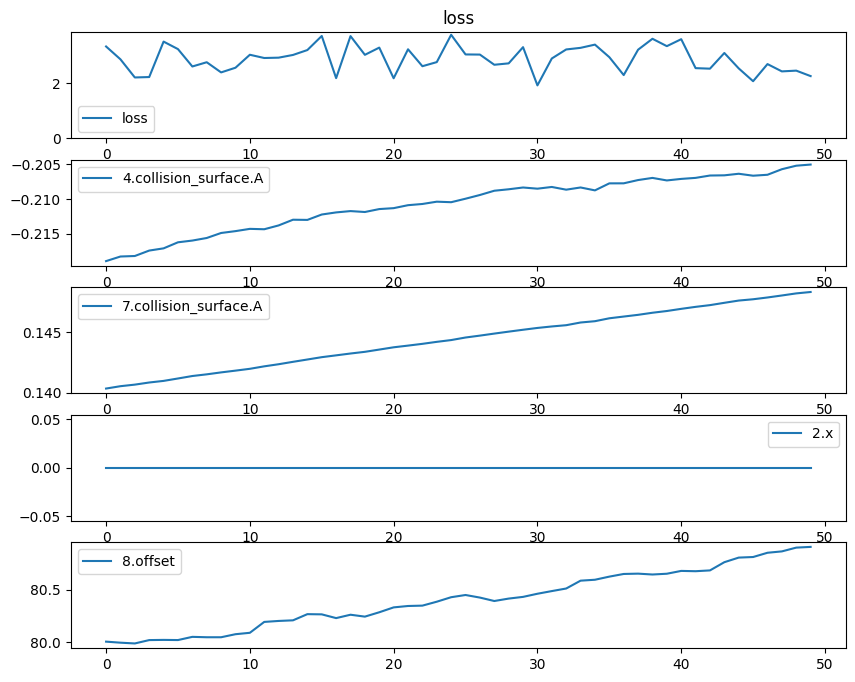

Best loss 1.9177398681640625 at iteration 31 / 50
    2.x tensor(0., dtype=torch.float64)
    4.collision_surface.A tensor(-0.2085, dtype=torch.float64)
    7.collision_surface.A tensor(0.1454, dtype=torch.float64)
    8.offset tensor(80.4627, dtype=torch.float64)

A -0.2047957755510121
B 0.14844979989204166
G0 0.0
G1 -900.0
G2 80.89787842347056
ROD X 0.0
ROD Y 0.0
ROD Z 919.0909250779561


In [4]:
param_groups = [
    {'params': [A], 'lr': 1e-5},
    {'params': [B], 'lr': 1e-5},
    #{'params': [G1], 'lr': 10},
    {'params': [G0], 'lr': 10},
    {'params': [G2], 'lr': 10},
]

record = tlm.optimize(
    optics,
    optimizer = optim.SGD(param_groups),
    sampling = {"xx": 50, "disable_viewer": True, "letter": "both"},
    dim = 3,
    num_iter = 50
)


plot_record(record, param_groups, optics)
record.best()

#settobest(optics, record, param_groups)

print("A", A.item())
print("B", B.item())
print("G0", G0.item())
print("G1", G1.item())
print("G2", G2.item())

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

xxrender(optics, sampling={"xx": 100, "letter": "both"}, extra_artists={Secondary: tlm.ForwardArtist(lambda mod: mod.collision_surface)})

In [3]:
with torch.no_grad():
    part_primary = tess_mirror(xxgrid(499, 100), primary_data.value.tf(), primary)
    part_secondary = tess_mirror(xxgrid(1.1*secondary.diameter / 2, 100), secondary_data.value.tf(), secondary)

part_sides = makesides(part_primary.vectors.dtype)  

final_part = mesh.Mesh(np.concatenate([
    part_primary.data,
    part_secondary.data,
    part_sides.data
]))

final_part.save("double.stl")

# Print rod position
target = rod_data.value.target()
print("ROD X", target[1].item())
print("ROD Y", target[2].item())
print("ROD Z", -target[0].item())

ROD X 0.0
ROD Y 0.0
ROD Z 919.9936476149196
